In [1]:
import MySQLdb
from mysql_cred import mysql_user, mysql_passowrd, mysql_database
from pprint import pprint
import pandas as pd
import numpy as np

from IPython.display import Image

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime
import re

mysql_ip = '158.85.198.80'
mysql_port = 3306

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [2]:
con = MySQLdb.connect(mysql_ip, mysql_user, mysql_passowrd, mysql_database, port = mysql_port)

In [3]:
def exec_pd(query, printit = False):
    con = MySQLdb.connect(mysql_ip, mysql_user, mysql_passowrd, mysql_database, port = mysql_port)
    cursor = con.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    #pprint(result)
    df = pd.DataFrame.from_records(list(result))
    if printit:
        print df
    return df

def exec_list(query, printit = False):
    con = MySQLdb.connect(mysql_ip, mysql_user, mysql_passowrd, mysql_database, port = mysql_port)
    cursor = con.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    #pprint(result)
    df = list(result)
    if printit:
        print df
    return df

## rout_routeinfo and rout_routes

the information on routes does not change. i wrote unique values from this table to a textfile in order to avoid having to query the table later.

rout_routes contain exactly the same information is rout_routinfo.

In [139]:
routeinfo = pd.read_csv('routeinfo.txt', sep = '\t')
routeinfo

,sched_num,name,abbr,routeid,number,origin,destination,direction,color,holidays,num_stns,stations
0,35,Pittsburg/Bay Point - SFIA/Millbrae,PITT-SFIA,ROUTE 1,1,PITT,SFIA,NaN,#ffff33,1,26,"PITT,NCON,CONC,PHIL,WCRK,LAFY,ORIN,ROCK,MCAR,1..."
1,35,Millbrae/SFIA - Pittsburg/Bay Point,SFIA-PITT,ROUTE 2,2,SFIA,PITT,NaN,#ffff33,1,26,"MLBR,SFIA,SBRN,SSAN,COLM,DALY,BALB,GLEN,24TH,1..."
2,35,Fremont - Richmond,FRMT-RICH,ROUTE 3,3,FRMT,RICH,NaN,#ff9933,1,18,"FRMT,UCTY,SHAY,HAYW,BAYF,SANL,COLS,FTVL,LAKE,1..."
3,35,Richmond - Fremont,RICH-FRMT,ROUTE 4,4,RICH,FRMT,NaN,#ff9933,1,18,"RICH,DELN,PLZA,NBRK,DBRK,ASHB,MCAR,19TH,12TH,L..."
4,35,Fremont - Daly City,FRMT-DALY,ROUTE 5,5,FRMT,DALY,NaN,#339933,0,19,"FRMT,UCTY,SHAY,HAYW,BAYF,SANL,COLS,FTVL,LAKE,W..."
5,35,Daly City - Fremont,DALY-FRMT,ROUTE 6,6,DALY,FRMT,NaN,#339933,0,19,"DALY,BALB,GLEN,24TH,16TH,CIVC,POWL,MONT,EMBR,W..."
6,35,Richmond - Daly City/Millbrae,RICH-MLBR,ROUTE 7,7,RICH,MLBR,NaN,#ff0000,0,23,"RICH,DELN,PLZA,NBRK,DBRK,ASHB,MCAR,19TH,12TH,W..."
7,35,Millbrae/Daly City - Richmond,MLBR-RICH,ROUTE 8,8,MLBR,RICH,NaN,#ff0000,0,23,"MLBR,SBRN,SSAN,COLM,DALY,BALB,GLEN,24TH,16TH,C..."
8,35,Dublin/Pleasanton - Daly City,DUBL-DALY,ROUTE 11,11,DUBL,DALY,NaN,#0099cc,1,17,"DUBL,WDUB,CAST,BAYF,SANL,COLS,FTVL,LAKE,WOAK,E..."
9,35,Daly City - Dublin/Pleasanton,DALY-DUBL,ROUTE 12,12,DALY,DUBL,NaN,#0099cc,1,17,"DALY,BALB,GLEN,24TH,16TH,CIVC,POWL,MONT,EMBR,W..."


###list of routes and stations

In [63]:
routes = routeinfo.number.values
routes

array([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 19, 20])

In [64]:
st = routeinfo.stations.values
stations = []
for s in st:
    if len(s) > 0:
        stations += (s.split(','))

stations = list(set(stations))
stations = np.asarray(stations)
stations

array(['SHAY', 'FTVL', 'NCON', 'COLS', 'WCRK', 'WOAK', 'CONC', 'CAST',
       'ORIN', 'SFIA', 'WDUB', 'DALY', 'EMBR', 'CIVC', 'SBRN', 'HAYW',
       'LAFY', 'DBRK', '12TH', 'PHIL', 'PITT', 'NBRK', 'MONT', 'POWL',
       'ROCK', 'SANL', '16TH', 'FRMT', 'BALB', 'DELN', 'MCAR', 'DUBL',
       '24TH', 'PLZA', 'MLBR', 'GLEN', 'BAYF', 'LAKE', 'ASHB', 'UCTY',
       '19TH', 'COLM', 'RICH', 'SSAN', 'OAKL'], 
      dtype='|S4')

##sched_special

this can make things pretty complicated. i grabbed all unique information and the earliest that information was available. we see below that some the information is pretty crucial: scheduled delays and no train service to name a few. more processing needs to be done to clean the data up. we need to come back to this later. 

In [77]:
sched_special = exec_pd('select min(fetchtime) as min_fetchtime, start_date, start_time, \
        end_date, end_time, text_, orig, dest, day_of_week, routes_affected \
        from sched_special group by start_date, start_time, end_date, end_time, \
        text_, orig, dest, day_of_week, routes_affected order by min_fetchtime')
sched_special.columns = ['min_fetchtime', 'start_date', 'start_time', 'end_date', 'end_time', \
                        'text_', 'orig', 'dest', 'day_of_week', 'routes_affected']
sched_special

,min_fetchtime,start_date,start_time,end_date,end_time,text_,orig,dest,day_of_week,routes_affected
0,2015-06-04 01:43:04.919920,07/05/2015,06:00,07/05/2015,15:00,Delays on Pittsburg/Bay Point line,None,None,0,"ROUTE 1, ROUTE 2"
1,2015-06-04 01:43:04.919920,07/12/2015,00:01,07/12/2015,12:00,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
2,2015-06-04 01:43:04.919920,07/11/2015,00:01,07/11/2015,23:59,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
3,2015-06-04 01:43:04.919920,12/09/2014,23:00,12/31/2015,04:00,AC Transit is running enhanced late night bus ...,None,None,"0, 1, 2, 3, 4, 5, 6","ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
4,2015-06-04 01:43:04.919920,06/21/2015,06:00,06/21/2015,15:00,Delays on Pittsburg/Bay Point line,None,None,0,"ROUTE 1, ROUTE 2"
5,2015-06-04 01:43:04.919920,06/20/2015,06:00,06/20/2015,15:00,Delays on Pittsburg/Bay Point line,None,None,6,"ROUTE 1, ROUTE 2"
6,2015-06-04 01:43:04.919920,06/14/2015,00:01,06/14/2015,23:59,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
7,2015-06-04 01:43:04.919920,06/07/2015,00:01,06/07/2015,12:00,Bus bridge between Fruitvale and Coliseum Station,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
8,2015-06-04 01:43:04.919920,06/06/2015,00:01,06/06/2015,23:59,Bus bridge between Fruitvale and Coliseum Station,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
9,2015-06-04 01:43:04.919920,06/13/2015,00:01,06/13/2015,23:59,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."


##adv_count

count of number trains active. below i look at data in one week, and train the count as a function of time for each day of the week.

In [80]:
exec_pd('describe adv_count')

,0,1,2,3,4,5
0,uid,bigint(20),NO,PRI,None,auto_increment
1,fetchtime,varchar(26),YES,,None,
2,date,varchar(10),YES,,None,
3,time,varchar(15),YES,,None,
4,traincount,smallint(6),YES,,None,


In [176]:
adv_count = exec_pd('select distinct date, time, traincount from adv_count')
adv_count.columns = ['date', 'time', 'traincount']
adv_count.shape

(63667, 3)

In [182]:
adv_count['date_time'] = adv_count.date + ' ' + adv_count.time
adv_count.date_time = pd.to_datetime(adv_count.date_time, format = "%m/%d/%Y %H:%M:%S %p %Z").astype(datetime.datetime)
adv_count['time_time'] = pd.to_datetime(adv_count.time, format = "%H:%M:%S %p %Z").astype(datetime.datetime)
adv_count = adv_count.sort('date_time')

In [183]:
adv_count.head()

,date,time,traincount,date_time,time_time
12104,06/03/2015,23:43:00 PM PDT,24,2015-06-03 23:43:00,1900-01-01 23:43:00
12105,06/03/2015,23:44:00 PM PDT,23,2015-06-03 23:44:00,1900-01-01 23:44:00
12106,06/03/2015,23:45:00 PM PDT,23,2015-06-03 23:45:00,1900-01-01 23:45:00
12107,06/03/2015,23:46:00 PM PDT,23,2015-06-03 23:46:00,1900-01-01 23:46:00
12109,06/03/2015,23:47:00 PM PDT,22,2015-06-03 23:47:00,1900-01-01 23:47:00


In [188]:
ac_oneweek =adv_count[(adv_count['date'] < '06/29/2015') & (adv_count['date'] > '06/21/2015')]
ac_monday = ac_oneweek[ac_oneweek['date'] == '06/22/2015']
ac_tuesday = ac_oneweek[ac_oneweek['date'] == '06/23/2015']
ac_wednesday = ac_oneweek[ac_oneweek['date'] == '06/24/2015']
ac_thursday = ac_oneweek[ac_oneweek['date'] == '06/25/2015']
ac_friday = ac_oneweek[ac_oneweek['date'] == '06/26/2015']
ac_saturday = ac_oneweek[ac_oneweek['date'] == '06/27/2015']
ac_sunday = ac_oneweek[ac_oneweek['date'] == '06/28/2015']

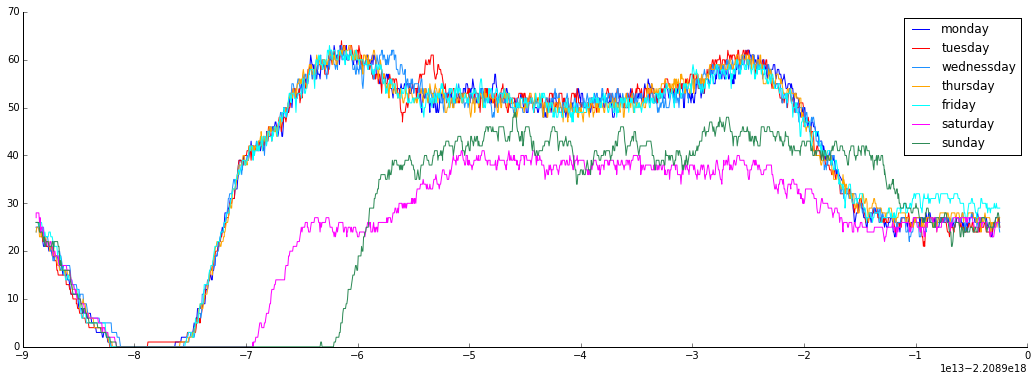

nice data


In [212]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
#dt = mpl.dates.datestr2num(ac_monday.time)
ax.plot(ac_monday.time_time, ac_monday.traincount, label = 'monday')
ax.plot(ac_tuesday.time_time, ac_tuesday.traincount, label = 'tuesday', color = 'red')
ax.plot(ac_wednesday.time_time, ac_wednesday.traincount, label = 'wednessday', color = 'dodgerblue')
ax.plot(ac_thursday.time_time, ac_thursday.traincount, label = 'thursday', color = 'orange')
ax.plot(ac_friday.time_time, ac_friday.traincount, label = 'friday', color = 'cyan')
ax.plot(ac_saturday.time_time, ac_saturday.traincount, label = 'saturday', color = 'magenta')
ax.plot(ac_sunday.time_time, ac_sunday.traincount, label = 'sunday', color = 'seagreen')

plt.legend()
remove_border()
plt.show()
print 'nice data'

looking at data for the entire length of time we have been collecting, we see a couple of interesting outlier behaviors: in the second full week on friday we see a abnormally high activity. it turns out this corresponds to the warriors championship parade (june 19). the following sunday (june 28) we see another unusually high volume of trains, this time corresponding the pride parade in sf. the following weekend on saturday (july 4) we see lower than normal volume on independence day as many people go out of town.
There is also a hugh spike (actually 2 of them) on july 8. it appears this is just bad data (see below).

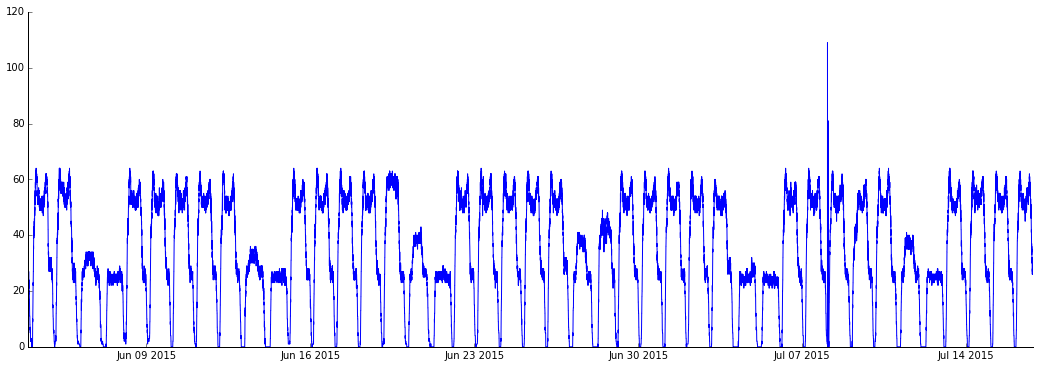

showing data from 06/03/2015 to 07/16/2015


In [216]:
plt.figure(figsize=(18, 6))
plt.plot(adv_count.date_time, adv_count.traincount)
remove_border()
plt.show()
print "showing data from " + str(min(adv_count.date)) + " to " + str(max(adv_count.date))

In [206]:
adv_count[adv_count['traincount'] > 80]

,date,time,traincount,date_time,time_time
50693,07/08/2015,02:32:00 AM PDT,109,2015-07-08 02:32:00,1900-01-01 02:32:00
50736,07/08/2015,03:15:00 AM PDT,81,2015-07-08 03:15:00,1900-01-01 03:15:00


In [208]:
print adv_count[adv_count['time'] == '02:32:00 AM PDT'].groupby('traincount').date.count()
print
print adv_count[adv_count['time'] == '03:15:00 AM PDT'].groupby('traincount').date.count()

traincount
0             31
1              5
2              4
3              2
109            1
Name: date, dtype: int64

traincount
0             28
1              9
2              5
81             1
Name: date, dtype: int64


##adv_elev

In [219]:
print list(exec_pd('describe adv_elev')[0])

['uid', 'fetchtime', 'date', 'time', 'id', 'station', 'type', 'description', 'posted', 'expires']


In [221]:
exec_pd('select * from adv_elev limit 5')

,0,1,2,3,4,5,6,7,8,9
0,1,2015-06-29 00:00:26.629730,06/28/2015,21:59:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None
1,2,2015-06-29 00:00:48.807348,06/28/2015,22:00:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None
2,3,2015-06-29 00:01:18.836357,06/28/2015,22:00:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None
3,4,2015-06-29 00:01:48.865358,06/28/2015,22:01:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None
4,5,2015-06-29 00:02:18.894405,06/28/2015,22:01:00 PM PDT,132159,BART,ELEVATOR,There are two elevators out of service at this...,Sun Jun 28 2015 08:07 PM PDT,None


In [224]:
adv_elev = exec_pd('select * from adv_elev')
adv_elev.columns = ['uid', 'fetchtime', 'date', 'time', 'id', 'station', 'type', 'description', 'posted', 'expires']

some of the columns (station, type, and expires) do not provide any information. we can remove these from our data collection in the future. date and time columns correpond to date and time at the time of call, which is redundant given that we record fetchtime. we can remove these columns as well.

In [248]:
stations = adv_elev.groupby('station').station.count()
print stations
print
types = adv_elev.groupby('type').station.count()
print types
print
expires = adv_elev.groupby('expires').station.count()
print expires

station
BART       124330
Null            6
Name: station, dtype: int64

type
ELEVATOR    124330
Null             6
Name: station, dtype: int64

expires
Null       6
Name: station, dtype: int64


In [249]:
adv_elev[adv_elev.station == 'Null']

,uid,fetchtime,date,time,id,station,type,description,posted,expires
27872,27873,2015-06-18 02:19:36.355139,06/18/2015,00:19:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27873,27874,2015-06-18 02:20:06.365497,06/18/2015,00:19:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27874,27875,2015-06-18 02:20:36.394703,06/18/2015,00:20:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27875,27876,2015-06-18 02:21:06.423959,06/18/2015,00:20:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27876,27877,2015-06-18 02:21:36.453213,06/18/2015,00:21:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null
27877,27878,2015-06-18 02:22:06.482424,06/18/2015,00:21:00 AM PDT,Null,Null,Null,Attention passengers: All elevators are in ser...,Null,Null


6 consecutive calls gave null values for a number of variables. this does impact us, however, since they all correspond to the case where there are no elevators out of service. later we see that we dont even really need these columns.

In [251]:
adv_elev = adv_elev[['uid', 'fetchtime', 'id', 'description', 'posted']]
adv_elev.head()

,uid,fetchtime,id,description,posted
23261,23262,2015-06-04 01:43:04.919920,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
23262,23263,2015-06-04 01:43:34.940328,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
23263,23264,2015-06-04 01:44:04.952860,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
23264,23265,2015-06-04 01:44:34.981868,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
23265,23266,2015-06-04 01:45:05.010830,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT


below we see the posted column corresponds to min_fetchtime, which makes sense. given that we most likely will join the different tables in fetchtime, we can remove this column as well. id is also useless for our purposes.

In [350]:
adv_elev = exec_pd('select min(fetchtime) as min_fetchtime, id, description, posted \
from adv_elev group by id, description, posted')
adv_elev.columns = ['min_fetchtime', 'id', 'description', 'posted']
adv_elev = adv_elev.sort('min_fetchtime')

In [351]:
adv_elev.head()

,min_fetchtime,id,description,posted
0,2015-06-04 01:43:04.919920,130816,There is one elevator out of service at this t...,Wed Jun 03 2015 10:08 PM PDT
1,2015-06-04 06:05:46.322038,130817,There are no elevators out of service at this ...,Thu Jun 04 2015 04:04 AM PDT
2,2015-06-04 06:38:17.735498,130818,There is one elevator out of service at this t...,Thu Jun 04 2015 04:37 AM PDT
3,2015-06-04 13:25:33.868372,130828,There are no elevators out of service at this ...,Thu Jun 04 2015 11:24 AM PDT
4,2015-06-05 10:42:23.369006,130912,There are no elevators out of service at this ...,Fri Jun 05 2015 08:42 AM PDT


In [425]:
adv_elev = exec_pd('select min(fetchtime) as min_fetchtime, description \
from adv_elev group by description')
adv_elev.columns = ['min_fetchtime', 'description']
adv_elev = adv_elev.sort('min_fetchtime')

In [426]:
desc = list(adv_elev.description.unique())
print len(desc)
desc[:5]

137


['There is one elevator out of service at this time:  Coliseum Platform Elevator.  Thank you.',
 'There are no elevators out of service at this time.  Thank you.',
 'There is one elevator out of service at this time:  19th St. Oakland Street Elevator.  Thank you.',
 'There is one elevator out of service at this time:  Berkeley Street Elevator.  Thank you.',
 'There is one elevator out of service at this time:  MacArthur S.F./Fremont Platform Elevator.  Thank you.']

building elevator features would require doing text processing to identify which stations have elevators that are out. this might not be the best use of time at this point, especially given that it this might not be a significantly predictive feature for delays. we can come back to this later if there is time.

In [427]:
print "descriptions without 'out of service at this time'"
print [x for x in desc if 'out of service at this time' not in x.lower()]
print
print "descriptions with 'in service'"
print [x for x in desc if 'in service'in x.lower()]

descriptions without 'out of service at this time'
['Attention passengers: All elevators are in service. Thank You.', 'ALL STATION ELEVATORS ARE IN SERVICE.']

descriptions with 'in service'
['Attention passengers: All elevators are in service. Thank You.', 'ALL STATION ELEVATORS ARE IN SERVICE.']


two simple rules can explain how many elevators are out: 
- look for word after is/are: 
    - if a number, then that number
    - if no or in, then zero

In [445]:
num_dict = {'no': 0, 'in':0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7}

desc = list(adv_elev.description)
elevs_out = []
for t in desc:
    elevs_out.append(num_dict[re.search('(is|are) (.*?) ', str(t.lower())).group(2)])

adv_elev['elevs_out'] = elevs_out

hours = list(adv_elev.min_fetchtime_dt.map(lambda x: int(x.strftime('%H'))))
adv_elev['hours'] = hours

adv_elev.head(5)

,min_fetchtime,description,elevs_out,min_fetchtime_dt,hours
108,2015-06-04 01:43:04.919920,There is one elevator out of service at this t...,1,2015-06-04 01:43:04.919920,1
11,2015-06-04 06:05:46.322038,There are no elevators out of service at this ...,0,2015-06-04 06:05:46.322038,6
100,2015-06-04 06:38:17.735498,There is one elevator out of service at this t...,1,2015-06-04 06:38:17.735498,6
104,2015-06-05 11:39:25.606226,There is one elevator out of service at this t...,1,2015-06-05 11:39:25.606226,11
120,2015-06-05 14:24:31.743054,There is one elevator out of service at this t...,1,2015-06-05 14:24:31.743054,14


In [446]:
adv_elev['min_fetchtime_dt'] = pd.to_datetime(adv_elev.min_fetchtime, format = "%Y-%m-%d %H:%M:%S.%f").astype(datetime.datetime)

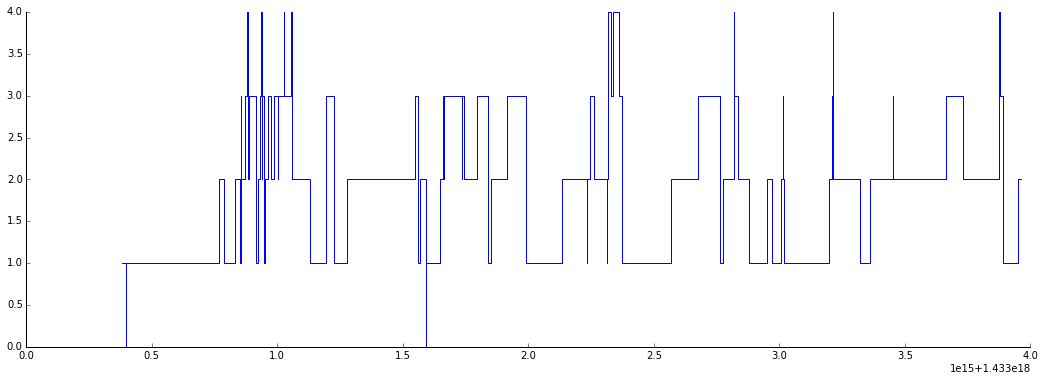

showing data from 2015-06-04 01:43:04.919920 to 2015-07-15 12:44:57.857593


In [455]:
plt.figure(figsize=(18, 6))
plt.step(adv_elev.min_fetchtime_dt, adv_elev.elevs_out, where='post')
#plt.plot(adv_elev.min_fetchtime_dt, adv_elev.min_fetchtime_dt.map(lambda x: x.strftime('%H')))

remove_border()
plt.show()
print "showing data from " + str(min(adv_elev.min_fetchtime_dt)) + " to " + str(max(adv_elev.min_fetchtime_dt))

<type 'int'>


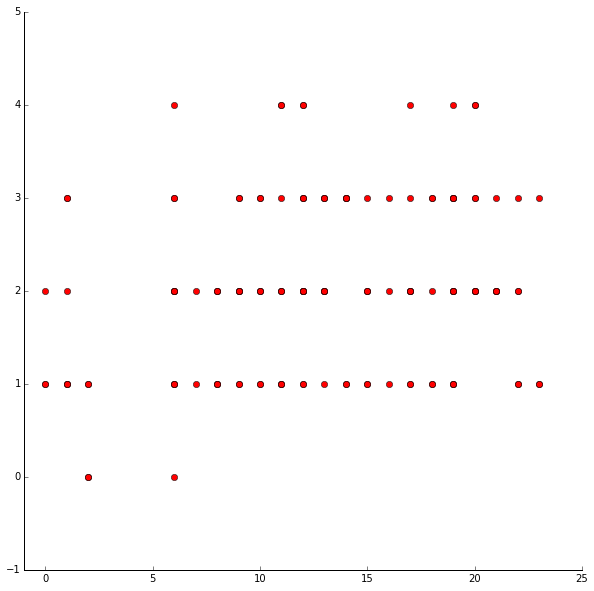

showing data from 2015-06-04 01:43:04.919920 to 2015-07-15 12:44:57.857593


In [480]:
plt.figure(figsize=(10, 10))
plt.plot(adv_elev.hours, adv_elev.elevs_out, 'ro')
plt.ylim([-1, 5])
plt.xlim([-1, 25])

remove_border()
plt.show()
print "showing data from " + str(min(adv_elev.min_fetchtime_dt)) + " to " + str(max(adv_elev.min_fetchtime_dt))

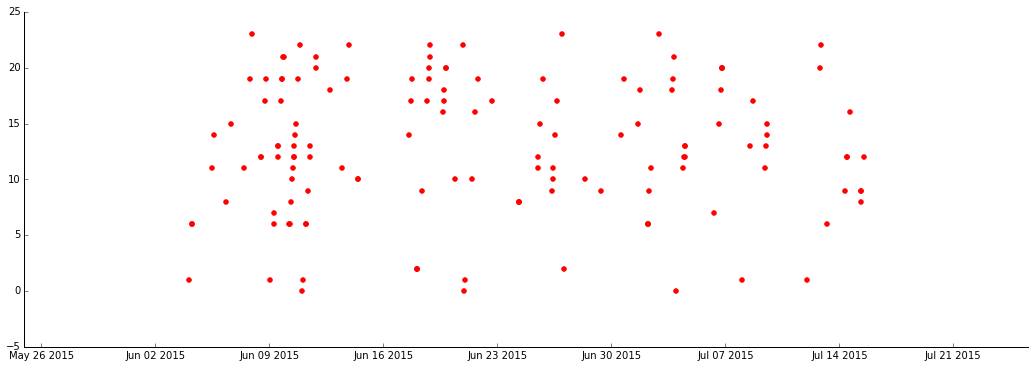

showing data from 2015-06-04 01:43:04.919920 to 2015-07-15 12:44:57.857593


In [438]:
plt.figure(figsize=(18, 6))

hours = list(adv_elev.min_fetchtime_dt.map(lambda x: x.strftime('%H')))
times = list(adv_elev.min_fetchtime_dt)


plt.scatter(times, hours, color = 'red')
remove_border()
plt.show()
print "showing data from " + str(min(adv_elev.min_fetchtime_dt)) + " to " + str(max(adv_elev.min_fetchtime_dt))

##adv_bsa

In [306]:
print list(exec_pd('describe adv_bsa')[0])

['uid', 'fetchtime', 'date', 'time', 'id', 'station', 'type', 'description', 'posted', 'expires']


In [309]:
adv_bsa = exec_pd('select * from adv_bsa')
adv_bsa.columns = ['uid', 'fetchtime', 'date', 'time', 'id', 'station', 'type', 'description', 'posted', 'expires']
adv_bsa.head(5)

,uid,fetchtime,date,time,id,station,type,description,posted,expires
0,1,2015-06-29 00:00:26.629730,06/28/2015,21:59:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null
1,2,2015-06-29 00:00:48.807348,06/28/2015,22:00:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null
2,3,2015-06-29 00:01:18.836357,06/28/2015,22:00:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null
3,4,2015-06-29 00:01:48.865358,06/28/2015,22:01:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null
4,5,2015-06-29 00:02:18.894405,06/28/2015,22:01:00 PM PDT,Null,Null,Null,No delays reported.,Null,Null


In [315]:
print adv_bsa.groupby('station').station.count()
print
print adv_bsa.groupby('type').station.count()
print
print adv_bsa.groupby('expires').station.count()
print
no_delay = adv_bsa[adv_bsa['description'] == 'No delays reported.']
print "no delay cases:"
print no_delay.groupby('station').station.count()
print
print no_delay.groupby('type').station.count()
print
print no_delay.groupby('expires').station.count()

station
BART       36263
Null       94690
Name: station, dtype: int64

type
DELAY    36263
Null     94690
Name: station, dtype: int64

expires
Null                            94690
Thu Dec 31 2037 11:59 PM PST    36263
Name: station, dtype: int64

no delay cases:
station
Null       94690
Name: station, dtype: int64

type
Null    94690
Name: station, dtype: int64

expires
Null       94690
Name: station, dtype: int64


when there is no delay reported, id, statio, type, expired are null. when there is a delay, they take on  values that are not informative. similar to elevator advisories, we really only need min_fetchtime and description, and intepreting the delay message can be complicated, given that it appears there is a strict rule in place in terms of the format of the text description. this steers us away from interpretting delays from the advisory messages.

In [320]:
adv_bsa = exec_pd('select min(fetchtime) as min_fetchtime, description \
from adv_bsa group by description')
adv_bsa.columns = ['min_fetchtime', 'description']
adv_bsa = adv_bsa.sort('min_fetchtime')
adv_bsa.head()

,min_fetchtime,description
90,2015-06-04 01:43:04.919920,No delays reported.
128,2015-06-04 18:58:16.741598,There is a 10-minute delay on the Daly City Li...
42,2015-06-04 19:04:46.981092,BART is recovering from an earlier problem. Th...
74,2015-06-04 19:09:47.169302,BART is recovering from an earlier problem. Th...
215,2015-06-04 19:39:18.246734,There is a major delay system wide due to an e...


In [321]:
list(adv_bsa.description.unique())[:10]

##sched_load

In [207]:
sched_load = exec_pd('select station, route, train, passload from sched_load;')
sched_load.columns = ['station', 'route', 'train', 'passload']
sched_load.head()

,station,route,train,passload
0,SHAY,3,1,1
1,SHAY,3,2,1
2,SHAY,3,3,1
3,SHAY,3,4,1
4,SHAY,3,5,1


In [208]:
sched_load.groupby('passload').station.count()

passload
1           13398
2            1072
3             396
Name: station, dtype: int64

In [209]:
pd.pivot_table(sched_load, columns = 'route', index = 'passload', values = 'station', aggfunc=lambda x: len(x))

route,1,2,3,4,5,6,7,8,11,12
passload,,,,,,,,,,
1,2079,2055,1283,1312,886,893,1205,1207,1248,1230
2,204,218,76,51,66,69,106,113,73,96
3,83,93,9,5,36,26,46,37,33,28


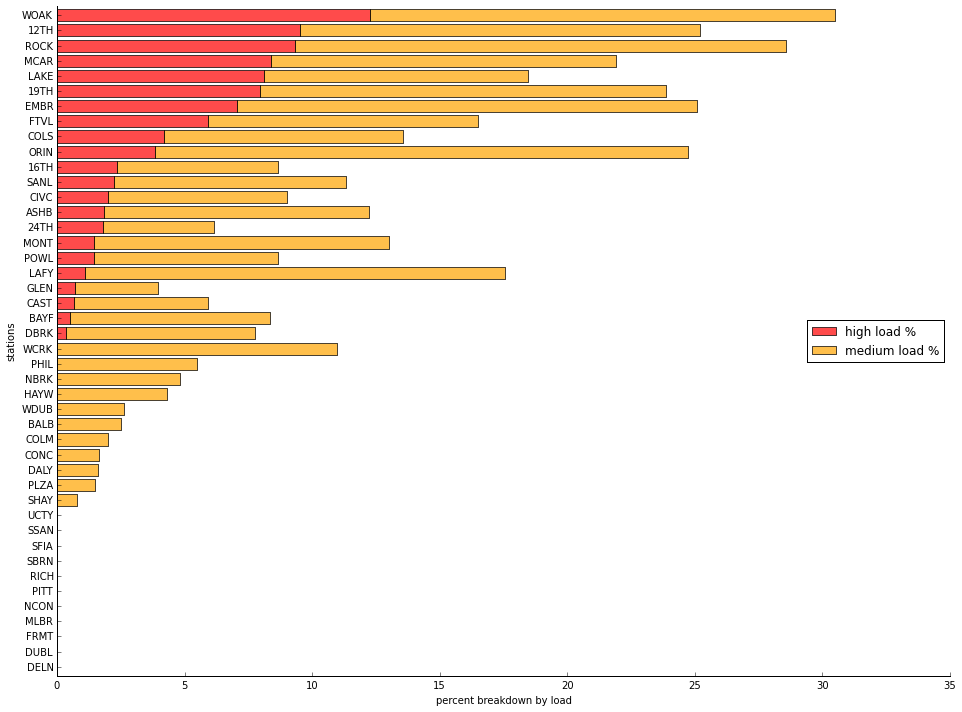

In [227]:
piv = pd.pivot_table(sched_load, columns = 'passload', index = 'station', values = 'route', aggfunc=lambda x: len(x))
piv = piv.apply(lambda x : x * 100 / x.sum(), axis=1)
piv = piv.fillna(0)
piv = piv.sort([3, 2], ascending=[1, 1])

fig, ax = plt.subplots(figsize=(16,12))
labels = piv.index
locations = np.arange(len(labels))
width = 2
#rectlocations = locations - (width / 2.0)

ax.barh(locations, piv[3], align='center', alpha=0.7, color = 'red')
ax.barh(locations, piv[2], align='center', alpha=0.7, left = piv[3], color = 'orange')
plt.yticks(locations, labels)
ax.set_ylim(min(locations) - 0.6, max(locations) + 0.6)
ax.set_xlabel('percent breakdown by load')
ax.set_ylabel('stations')
ax.legend(('high load %', 'medium load %'), loc = 5)

remove_border()

there is clearly some stations where there is a lot more passenger load, and a number of stations where we see no high or medium load. the top stations (top 8: west oakland, 12th st, rockridge, mcarthur, lake merritt, 19th st, and embarcadero, fruitvale) are all central to the system map, which makes sense. the low stations are all on the edges of the map.

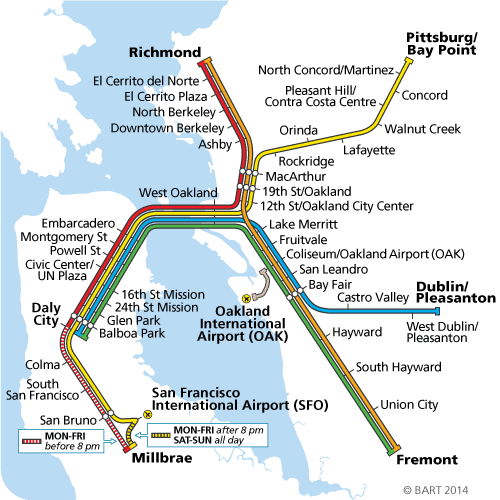

In [157]:
Image(filename='system-map.png') 

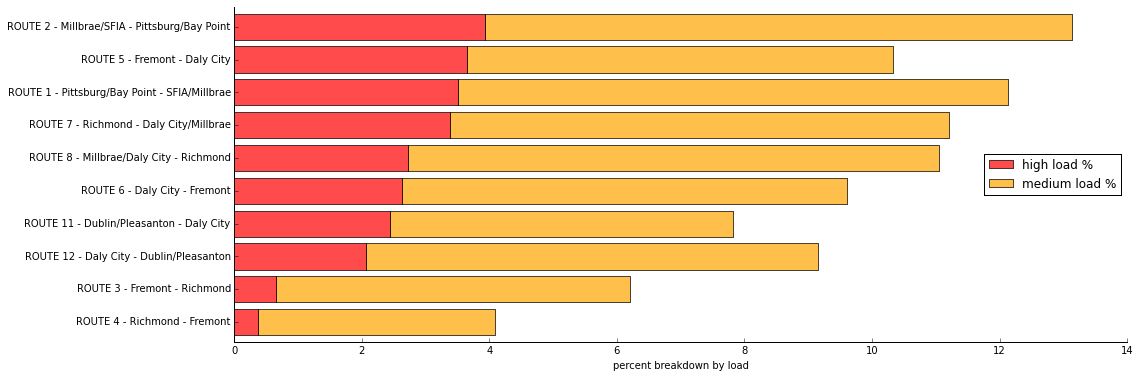

In [226]:
piv = pd.pivot_table(sched_load, columns = 'passload', index = 'route', values = 'station', aggfunc=lambda x: len(x))
piv = piv.apply(lambda x : x * 100 / x.sum(), axis=1)
piv = piv.fillna(0)
piv = piv.sort([3, 2], ascending=[1, 1])
piv['route'] = piv.index
piv = piv.merge(routeinfo, left_on = 'route', right_on = 'number')

fig, ax = plt.subplots(figsize=(16, 6))
labels = piv.routeid + " - " + piv.name
locations = np.arange(len(labels))
width = 2
#rectlocations = locations - (width / 2.0)

ax.barh(locations, piv[3], align='center', alpha=0.7, color = 'red')
ax.barh(locations, piv[2], align='center', alpha=0.7, left = piv[3], color = 'orange')

plt.yticks(locations, labels)
ax.set_ylim(min(locations) - 0.6, max(locations) + 0.6)
ax.set_xlabel('percent breakdown by load')
#ax.set_ylabel('routes')
ax.legend(('high load %', 'medium load %'), loc = 5)

remove_border()

we see that aside from routes 3 and 4, we see between 2 to 4% of high load. 3 and 4 dont cross the bay, so it makes sense that they dont see as much load. there is no load information for routes 19 and 20, which move between colesium and oakland airport.

(0, 91)

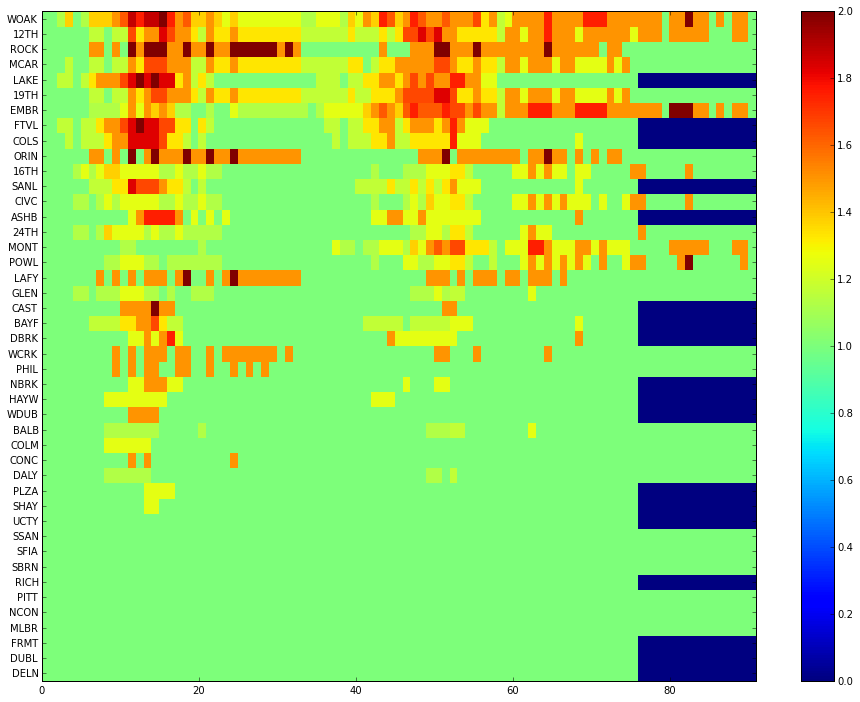

In [250]:
stations_by_load = ['DELN', 'DUBL', 'FRMT', 'MLBR', 'NCON', 'PITT', 'RICH', 'SBRN', 'SFIA', 'SSAN', 'UCTY', 'SHAY',\
                    'PLZA', 'DALY', 'CONC', 'COLM', 'BALB', 'WDUB', 'HAYW', 'NBRK', 'PHIL', 'WCRK', 'DBRK', 'BAYF',\
                    'CAST', 'GLEN', 'LAFY', 'POWL', 'MONT', '24TH', 'ASHB', 'CIVC', 'SANL', '16TH', 'ORIN', 'COLS',\
                    'FTVL', 'EMBR', '19TH', 'LAKE', 'MCAR', 'ROCK', '12TH', 'WOAK']

piv = pd.pivot_table(sched_load, columns = 'train', index = ['station'], values = 'passload').T
piv = piv.fillna(0)

piv = piv[stations_by_load].T
fig, ax = plt.subplots(figsize=(16,12))
labels = piv.index

locations = np.arange(len(labels))+0.5

cax = ax.pcolor(piv)
fig.colorbar(cax)
plt.yticks(locations, labels)
ax.set_ylim(0, max(locations) + 0.5)
ax.set_xlim(0,91)


##sched_routesched

values for 'day' are wd (weekday), sa (saturday), and su (sunday).
origtime refers to time train is at station.

In [257]:
columns = ['day', 'route', 'train', 'station', 'origtime', 'bikeflag']
sched_routesched = exec_pd('select day, route, train, station, origtime, bikeflag from sched_routesched')
sched_routesched.columns = columns
sched_routesched.head()

,day,route,train,station,origtime,bikeflag
0,wd,1,1,PITT,4:02 AM,1
1,wd,1,1,NCON,4:08 AM,1
2,wd,1,1,CONC,4:12 AM,1
3,wd,1,1,PHIL,4:17 AM,1
4,wd,1,1,WCRK,4:20 AM,1


In [292]:
sched_routesched['time'] = pd.to_datetime(sched_routesched['origtime'], '%I:%M %p')

In [293]:
sched_routesched.head()

,day,route,train,station,origtime,bikeflag,time
0,wd,1,1,PITT,4:02 AM,1,4:02 AM
1,wd,1,1,NCON,4:08 AM,1,4:08 AM
2,wd,1,1,CONC,4:12 AM,1,4:12 AM
3,wd,1,1,PHIL,4:17 AM,1,4:17 AM
4,wd,1,1,WCRK,4:20 AM,1,4:20 AM


In [294]:
load_routesched = sched_load.merge(sched_routesched[sched_routesched['day']=='wd'], on = ['route', 'train', 'station'])
load_routesched['time'] = pd.to_datetime(load_routesched['origtime'], '%I:%M %p')

In [295]:
load_routesched.head()

,station,route,train,passload,day,origtime,bikeflag,time
0,SHAY,3,1,1,wd,4:10 AM,1,4:10 AM
1,SHAY,3,2,1,wd,4:25 AM,1,4:25 AM
2,SHAY,3,3,1,wd,4:40 AM,1,4:40 AM
3,SHAY,3,4,1,wd,4:55 AM,1,4:55 AM
4,SHAY,3,5,1,wd,5:10 AM,1,5:10 AM


In [394]:
min(load_routesched[load_routesched['train']==1]['time'])

Timestamp('2015-07-25 04:00:00')

###scrap the plot below... i dont think its accurate

([<matplotlib.axis.XTick at 0x12bc6fb50>,
 <a list of 5 Text xticklabel objects>)

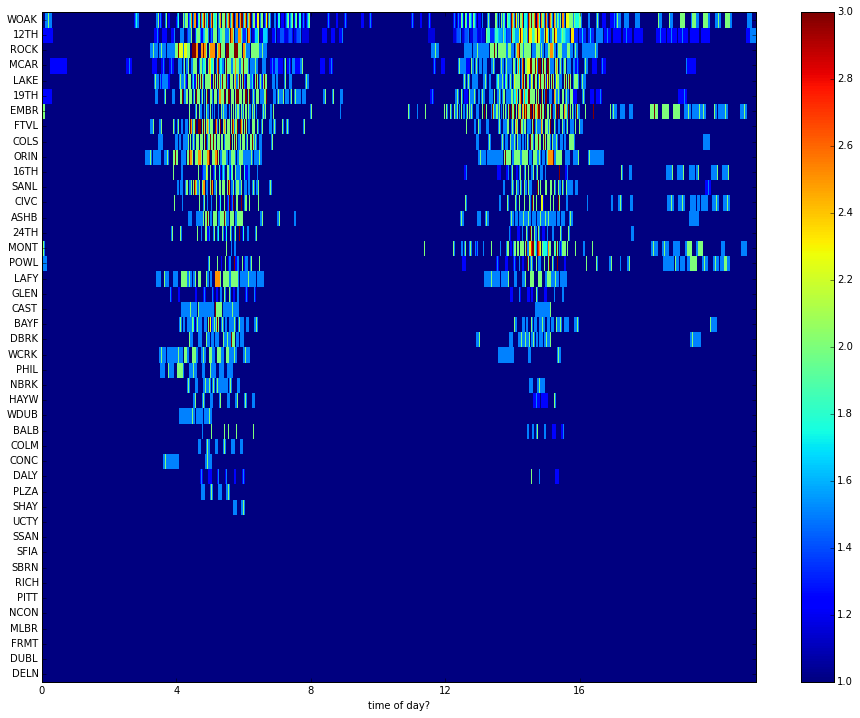

In [389]:
stations_by_load = ['DELN', 'DUBL', 'FRMT', 'MLBR', 'NCON', 'PITT', 'RICH', 'SBRN', 'SFIA', 'SSAN', 'UCTY', 'SHAY',\
                    'PLZA', 'DALY', 'CONC', 'COLM', 'BALB', 'WDUB', 'HAYW', 'NBRK', 'PHIL', 'WCRK', 'DBRK', 'BAYF',\
                    'CAST', 'GLEN', 'LAFY', 'POWL', 'MONT', '24TH', 'ASHB', 'CIVC', 'SANL', '16TH', 'ORIN', 'COLS',\
                    'FTVL', 'EMBR', '19TH', 'LAKE', 'MCAR', 'ROCK', '12TH', 'WOAK']

piv1 = pd.pivot_table(load_routesched, columns = 'time', index = ['station'], values = 'passload').T
piv1 = piv1.bfill()
piv1 = piv1.ffill()
#piv1 = piv1.fillna(0)
piv1 = piv1[stations_by_load].T

piv2 = pd.pivot_table(load_routesched, columns = 'time', index = ['station'], values = 'passload').T
piv2 = piv2.ffill()
piv2 = piv2.bfill()
#piv2 = piv2.fillna(0)
piv2 = piv2[stations_by_load].T

piv = (piv1+piv2)/2

fig, ax = plt.subplots(figsize=(16,12))
labels = piv.index

locations = np.arange(len(labels))+0.5

cax = ax.pcolor(piv)
fig.colorbar(cax)
plt.yticks(locations, labels)
ax.set_ylim(0, max(locations) + 0.5)
ax.set_xlim(0,1275)
plt.xlabel('time of day?')
plt.xticks([0, 240, 480, 720, 960],['0', '4', '8', '12', '16'])


In [258]:
sched_routesched.groupby('day').day.count()

day
sa     10008
su      6868
wd     15622
Name: day, dtype: int64

bad data...

In [271]:
sched_routesched[sched_routesched['bikeflag']==0]

,day,route,train,station,origtime,bikeflag
30030,su,5,0,NULL,NULL,0
30031,su,6,0,NULL,NULL,0
30032,su,7,0,NULL,NULL,0
30033,su,8,0,NULL,NULL,0


In [272]:
sched_routesched[sched_routesched['station']=='NULL']

,day,route,train,station,origtime,bikeflag
30030,su,5,0,NULL,NULL,0
30031,su,6,0,NULL,NULL,0
30032,su,7,0,NULL,NULL,0
30033,su,8,0,NULL,NULL,0


##rt_etd

In [4]:
print list(exec_pd('describe rt_etd')[0])

['uid', 'fetchtime', 'date', 'time', 'name', 'abbr', 'destination', 'abbreviation', 'minutes', 'platform', 'direction', 'length', 'color', 'hexcolor', 'bikeflag']


In [15]:
mins = exec_pd("select case when minutes = 'Leaving' then 0 else minutes end as mins, \
        count(*) as cnt from rt_etd group by mins order by mins")

In [22]:
mins.columns = ['minutes', 'cnt']
mins['minutes'] = mins['minutes'].astype(float)
mins.head()

,minutes,cnt
0,0,1299049
1,1,630501
2,10,1055189
3,100,8689
4,101,7763


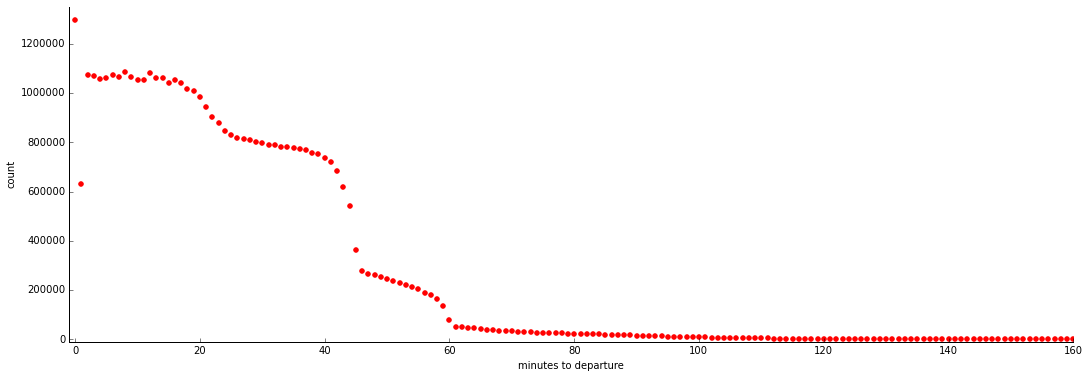

In [231]:
plt.figure(figsize=(18, 6))
plt.scatter(mins.minutes, mins.cnt, color = 'red')
plt.xlim(-1, 160)
plt.ylim(-10000, 1350000)
plt.xlabel('minutes to departure')
plt.ylabel('count')
remove_border()
plt.show()

i think as a first attempt it makes sense to look at rockridge as the one station we want to predict delays for. it only sits on one route for each direction, and according to loads it is a pretty busy station, which mean we probably will have more delays to work with. i chose the milbrae-pittsburgh direction, since it is coming from san francisco and is most likely carrying more passengers in that direction.

In [395]:
exec_pd('select count(*) from rt_etd')

,0
0,54885367


In [595]:
exec_pd("select * from rt_etd where abbr = 'ROCK' and abbreviation = 'PITT' and minutes = 'Leaving' limit 10")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,421,2015-06-29 00:00:48.807348,06/28/2015,10:00:18 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,10,YELLOW,#ffff33,1
1,761,2015-06-29 00:01:18.836357,06/28/2015,10:00:48 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,10,YELLOW,#ffff33,1
2,14989,2015-06-29 00:22:19.691081,06/28/2015,10:21:48 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,1,YELLOW,#ffff33,1
3,15329,2015-06-29 00:22:49.720107,06/28/2015,10:22:18 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,9,YELLOW,#ffff33,1
4,31628,2015-06-29 00:46:50.611687,06/28/2015,10:46:22 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,9,YELLOW,#ffff33,1
5,31964,2015-06-29 00:47:20.640679,06/28/2015,10:46:48 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,9,YELLOW,#ffff33,1
6,43750,2015-06-29 01:04:51.370806,06/28/2015,11:04:18 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,10,YELLOW,#ffff33,1
7,44082,2015-06-29 01:05:21.399822,06/28/2015,11:04:48 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,10,YELLOW,#ffff33,1
8,69354,2015-06-29 01:42:52.813173,06/28/2015,11:42:18 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,10,YELLOW,#ffff33,1
9,69662,2015-06-29 01:43:22.842255,06/28/2015,11:42:48 PM PDT,Rockridge,ROCK,Pittsburg/Bay Point,PITT,Leaving,1,North,10,YELLOW,#ffff33,1


In [398]:
exec_pd("select count(*) from rt_etd where abbr = 'ROCK' and abbreviation = 'PITT'")

,0
0,380484


In [362]:
rock = exec_pd("select * from rt_etd where abbr = 'ROCK' and abbreviation = 'PITT'")
columns = list(exec_pd('describe rt_etd')[0])
rock.columns = columns

In [363]:
rock = rock[['fetchtime', 'date', 'time', 'minutes', 'length']]
rock['date_time'] = rock['date']+' '+rock['time']
rock['date_time'] = pd.to_datetime(rock['date_time'], format = "%m/%d/%Y %I:%M:%S %p %Z")#.astype(datetime.datetime)
rock = rock.sort('date_time')

rock = rock[['date_time', 'date', 'minutes', 'length']]
rock.head()

,date_time,date,minutes,length
287982,2014-11-06 15:12:04,11/06/2014,33,10
287981,2014-11-06 15:12:04,11/06/2014,19,9
287980,2014-11-06 15:12:04,11/06/2014,4,10
58450,2015-06-03 23:42:51,06/03/2015,43,5
58449,2015-06-03 23:42:51,06/03/2015,18,5


there are instances (probably very likely) where we have two records consecutively saying 'leaving'. these belong to the same instance of a train at the station. we want to dedup these. the idea is, since the dataframe is sorted, we will start from the top and go down the list, and whever we hit a 'leaving', we account that, and ignore the other ones that are attached to it. this shouldn't provide any headaches as long as we have consistent data.

the above doesnt work, becuase at any point there are possibly multiple trains traveling in the same route, which means that we wont see 'leaving' consecutively. the only other alternative is ignoring ones that are within ~50 seconds of each other. lets try that.

In [364]:
rock_l = rock[rock['minutes'] == 'Leaving']
rock_l = rock_l.reset_index(drop = True)
rock_l['gap'] = 80
rock_l.head(5)

,date_time,date,minutes,length,gap
0,2015-06-04 00:00:18,06/04/2015,Leaving,5,80
1,2015-06-04 00:25:06,06/04/2015,Leaving,5,80
2,2015-06-04 00:25:33,06/04/2015,Leaving,5,80
3,2015-06-04 00:52:33,06/04/2015,Leaving,5,80
4,2015-06-04 00:53:03,06/04/2015,Leaving,5,80


In [365]:
for i in rock_l.index:
    try:
        rock_l.loc[i, 'gap'] = (rock_l.ix[i]['date_time'] - rock_l.ix[i-1]['date_time']).total_seconds()
    except:
        pass
rock_l.head()

,date_time,date,minutes,length,gap
0,2015-06-04 00:00:18,06/04/2015,Leaving,5,80
1,2015-06-04 00:25:06,06/04/2015,Leaving,5,1488
2,2015-06-04 00:25:33,06/04/2015,Leaving,5,27
3,2015-06-04 00:52:33,06/04/2015,Leaving,5,1620
4,2015-06-04 00:53:03,06/04/2015,Leaving,5,30


In [366]:
rock_l['train_date_time'] = rock_l['date_time'] - datetime.timedelta(hours = 2)
rock_l.head()

,date_time,date,minutes,length,gap,train_date_time
0,2015-06-04 00:00:18,06/04/2015,Leaving,5,80,2015-06-03 22:00:18
1,2015-06-04 00:25:06,06/04/2015,Leaving,5,1488,2015-06-03 22:25:06
2,2015-06-04 00:25:33,06/04/2015,Leaving,5,27,2015-06-03 22:25:33
3,2015-06-04 00:52:33,06/04/2015,Leaving,5,1620,2015-06-03 22:52:33
4,2015-06-04 00:53:03,06/04/2015,Leaving,5,30,2015-06-03 22:53:03


above: train days are different than normal days. they start at 2am and end at 2am the next day. so to convert things to train days, we subtract 2 hours from schedule and from actual times.

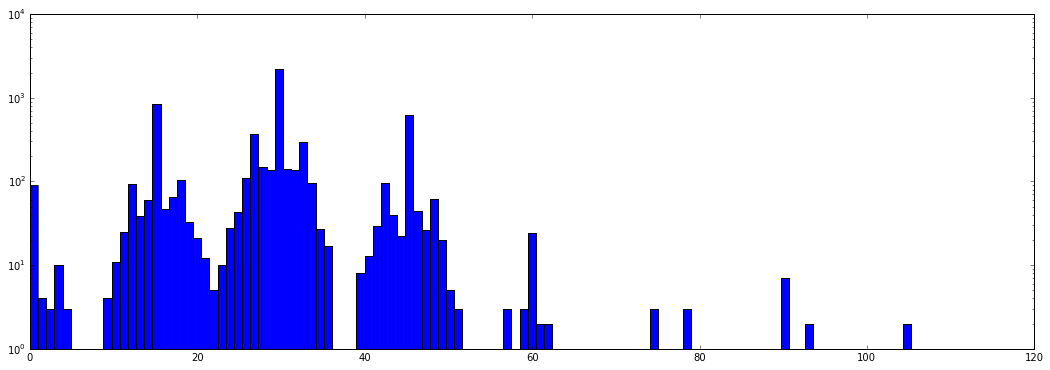

In [367]:
gaps = rock_l['gap'][rock_l['gap'] < 120]
ax = plt.figure(figsize=(18, 6))
ax = plt.hist(gaps, 120, log = True)
#plt.xticks([37, 45 , 54, 60, 70],['cutoff3', 'cutoff5', 'cutoff2','cutoff4','cutoff1']) #toggle this line 

looks like 70 seconds might be a reasonable cutoff

based on below results, trying 55...

In [368]:
rock_l = rock_l[['train_date_time', 'date_time', 'date', 'length']][rock_l['gap'] >= 54]
rock_l['train_date'] = rock_l['train_date_time'].apply(lambda x: str(x.date()))
rock_l.head()

,train_date_time,date_time,date,length,train_date
0,2015-06-03 22:00:18,2015-06-04 00:00:18,06/04/2015,5,2015-06-03
1,2015-06-03 22:25:06,2015-06-04 00:25:06,06/04/2015,5,2015-06-03
3,2015-06-03 22:52:33,2015-06-04 00:52:33,06/04/2015,5,2015-06-03
5,2015-06-04 02:46:05,2015-06-04 04:46:05,06/04/2015,5,2015-06-04
7,2015-06-04 03:05:06,2015-06-04 05:05:06,06/04/2015,10,2015-06-04


The above dataframe is actual arrival time of milbrae-pittsburg trains at rockridge station. we need to compare these with scheduled arrival times, which are stored in the sched_routesched table.

In [369]:
columns = ['day', 'route', 'train', 'station', 'origtime']
sched_routesched = exec_pd("select day, route, train, station, origtime from sched_routesched where route = '2' and station = 'ROCK'")
sched_routesched.columns = columns
sched_routesched[sched_routesched['day']=='su'].tail()

,day,route,train,station,origtime
192,su,2,46,ROCK,11:20 PM
193,su,2,47,ROCK,11:40 PM
194,su,2,48,ROCK,12:00 AM
195,su,2,49,ROCK,12:25 AM
196,su,2,50,ROCK,12:47 AM


In [370]:
sched_routesched.shape

(197, 5)

In [371]:
rock_l['day'] = rock_l['date_time'].apply(lambda x: np.where(x.isoweekday() < 6, 'wd',\
                                                                  np.where(x.isoweekday()==6, 'sa', 'su')))
rock_l.head(10)

,train_date_time,date_time,date,length,train_date,day
0,2015-06-03 22:00:18,2015-06-04 00:00:18,06/04/2015,5,2015-06-03,wd
1,2015-06-03 22:25:06,2015-06-04 00:25:06,06/04/2015,5,2015-06-03,wd
3,2015-06-03 22:52:33,2015-06-04 00:52:33,06/04/2015,5,2015-06-03,wd
5,2015-06-04 02:46:05,2015-06-04 04:46:05,06/04/2015,5,2015-06-04,wd
7,2015-06-04 03:05:06,2015-06-04 05:05:06,06/04/2015,10,2015-06-04,wd
10,2015-06-04 03:14:49,2015-06-04 05:14:49,06/04/2015,9,2015-06-04,wd
13,2015-06-04 03:31:49,2015-06-04 05:31:49,06/04/2015,8,2015-06-04,wd
15,2015-06-04 03:47:49,2015-06-04 05:47:49,06/04/2015,9,2015-06-04,wd
17,2015-06-04 04:01:07,2015-06-04 06:01:07,06/04/2015,10,2015-06-04,wd
19,2015-06-04 04:22:34,2015-06-04 06:22:34,06/04/2015,5,2015-06-04,wd


In [372]:
daysdf = rock_l[['date','day']].drop_duplicates().reset_index(drop = True)
daysdf.head()

,date,day
0,06/04/2015,wd
1,06/05/2015,wd
2,06/06/2015,sa
3,06/07/2015,su
4,06/08/2015,wd


In [373]:
sched = daysdf.merge(sched_routesched, how = 'left', on = 'day')
sched.head()

,date,day,route,train,station,origtime
0,06/04/2015,wd,2,1,ROCK,4:44 AM
1,06/04/2015,wd,2,2,ROCK,4:59 AM
2,06/04/2015,wd,2,3,ROCK,5:14 AM
3,06/04/2015,wd,2,4,ROCK,5:29 AM
4,06/04/2015,wd,2,5,ROCK,5:44 AM


In [374]:
sched['date_time'] = sched['date']+' '+sched['origtime']
sched['date_time'] = pd.to_datetime(sched['date_time'], format = "%m/%d/%Y %I:%M %p")
sched['train_date_time'] = sched['date_time'] - datetime.timedelta(hours = 2)
sched = sched.sort(['train_date_time']).reset_index(drop = True)
sched['train_date'] = sched['train_date_time'].apply(lambda x: str(x.date()))
sched.head(10)

,date,day,route,train,station,origtime,date_time,train_date_time,train_date
0,06/04/2015,wd,2,89,ROCK,12:00 AM,2015-06-04 00:00:00,2015-06-03 22:00:00,2015-06-03
1,06/04/2015,wd,2,90,ROCK,12:25 AM,2015-06-04 00:25:00,2015-06-03 22:25:00,2015-06-03
2,06/04/2015,wd,2,91,ROCK,12:47 AM,2015-06-04 00:47:00,2015-06-03 22:47:00,2015-06-03
3,06/04/2015,wd,2,1,ROCK,4:44 AM,2015-06-04 04:44:00,2015-06-04 02:44:00,2015-06-04
4,06/04/2015,wd,2,2,ROCK,4:59 AM,2015-06-04 04:59:00,2015-06-04 02:59:00,2015-06-04
5,06/04/2015,wd,2,3,ROCK,5:14 AM,2015-06-04 05:14:00,2015-06-04 03:14:00,2015-06-04
6,06/04/2015,wd,2,4,ROCK,5:29 AM,2015-06-04 05:29:00,2015-06-04 03:29:00,2015-06-04
7,06/04/2015,wd,2,5,ROCK,5:44 AM,2015-06-04 05:44:00,2015-06-04 03:44:00,2015-06-04
8,06/04/2015,wd,2,6,ROCK,5:59 AM,2015-06-04 05:59:00,2015-06-04 03:59:00,2015-06-04
9,06/04/2015,wd,2,7,ROCK,6:14 AM,2015-06-04 06:14:00,2015-06-04 04:14:00,2015-06-04


above: train days are different than normal days. they start at 2am and end at 2am the next day. so to convert things to train days, we subtract 2 hours from schedule and from actual times.

In [375]:
print sched.shape
print rock_l.shape
print sched.shape[0] - rock_l.shape[0]

(4215, 9)
(3924, 6)
291


thats not good...

lets start with one day...

are there days where the is an exact match between the number of records?

In [382]:
r = pd.DataFrame(rock_l.groupby('train_date').date.count())
r['d'] = r.index
s = pd.DataFrame(sched.groupby('train_date').date.count())
s['d'] = s.index
m = r.merge(s, on = 'd', suffixes = ['_r', '_s'])
print len(m)
print 'matching records =', sum(m.date_s == m.date_r)
print m.head(54)
print m[m.date_r == m.date_s]


54
matching records = 9
    date_r           d  date_s
0        3  2015-06-03       3
1       83  2015-06-04      91
2       83  2015-06-05      91
3       57  2015-06-06      56
4       50  2015-06-07      50
5       81  2015-06-08      91
6       82  2015-06-09      91
7       83  2015-06-10      91
8       83  2015-06-11      91
9       83  2015-06-12      91
10      58  2015-06-13      56
11      50  2015-06-14      50
12      82  2015-06-15      91
13      82  2015-06-16      91
14      81  2015-06-17      91
15      84  2015-06-18      91
16      83  2015-06-19      91
17      56  2015-06-20      56
18      50  2015-06-21      50
19      81  2015-06-22      91
20      85  2015-06-23      91
21      83  2015-06-24      91
22      76  2015-06-25      91
23      84  2015-06-26      91
24      56  2015-06-27      56
25      64  2015-06-28      50
26      83  2015-06-29      91
27      83  2015-06-30      91
28      81  2015-07-01      91
29      83  2015-07-02      91
30      83  201

this probably means we set the threshold too broadly above when we broke the arrivals above... going back to lower threshold to see if we get better results

tried a few thersholds. its hard to do this looking at the distributions we saw above. i will try to see if there is a reason we see consistently lower numbers for weekdays.

In [377]:
rock_ls = rock_l[rock_l['train_date']=='2015-06-10'].reset_index(drop = True)
sched_s = sched[sched['train_date']=='2015-06-10'].reset_index(drop = True)

In [378]:
print sched_s.shape
print rock_ls.shape

(91, 9)
(83, 6)


In [379]:
for i, r in sched_s.iterrows():
    print sched_s.ix[i]['date_time'], rock_ls.ix[i]['date_time'], rock_ls.ix[i]['date_time']-sched_s.ix[i]['date_time']

2015-06-10 04:44:00 2015-06-10 04:46:49 0:02:49
2015-06-10 04:59:00 2015-06-10 05:03:49 0:04:49
2015-06-10 05:14:00 2015-06-10 05:16:19 0:02:19
2015-06-10 05:29:00 2015-06-10 05:31:22 0:02:22
2015-06-10 05:44:00 2015-06-10 05:48:19 0:04:19
2015-06-10 05:59:00 2015-06-10 06:00:49 0:01:49
2015-06-10 06:14:00 2015-06-10 06:15:49 0:01:49
2015-06-10 06:29:00 2015-06-10 06:31:19 0:02:19
2015-06-10 06:44:00 2015-06-10 06:46:49 0:02:49
2015-06-10 06:59:00 2015-06-10 06:59:49 0:00:49
2015-06-10 07:11:00 2015-06-10 07:16:19 0:05:19
2015-06-10 07:14:00 2015-06-10 07:31:19 0:17:19
2015-06-10 07:26:00 2015-06-10 07:48:19 0:22:19
2015-06-10 07:29:00 2015-06-10 08:02:49 0:33:49
2015-06-10 07:41:00 2015-06-10 08:16:49 0:35:49
2015-06-10 07:44:00 2015-06-10 08:35:21 0:51:21
2015-06-10 07:56:00 2015-06-10 08:50:07 0:54:07
2015-06-10 07:59:00 2015-06-10 09:04:34 1:05:34
2015-06-10 08:14:00 2015-06-10 09:15:49 1:01:49
2015-06-10 08:29:00 2015-06-10 09:34:37 1:05:37
2015-06-10 08:44:00 2015-06-10 09:50:07 

KeyError: 83

there are two possible explanations:
1. bart doesnt stick to the schedule. it sends fewer trains than is scheduled, maybe throttling for delays and for the load of trains in real time.
2. when trains get really late, they line up right behind each other. when this happens, we might see them arrive one after the other, which messes up our threshold setting. one solution would be to have a variable threshold. but i dont know how to do this. are there other ways?

one way to check the above is to see how many trains leave the designated start station of the route (or arrive at the end station of the route) per train day. need to do this to determine if the issue is 1 or 2 above.

after looking at millbrae, sf airport pittsburg, and north concord stations, i still dont know if this is the case of throttling or simply threshold error in busy hours. either way i have devised the following logic to extract delays associated with each train on the schedule:

for each day, first, if the count of arrivals is more than shceduled, we are out of luck and i am throwing that day out.
if the count is equal or below, we make two passes. we start from the end of the day, and count back, associating each actual time to a smaller scheduled time that is closest to it.
if there are scheduled times left that have not been associated to an actual time yet, we backfill them, associating then to the closest larger arrival time. this makes sense because we are assuming there are trains arriving that are too close to each other and we cannot distinguish with our level of granularity.


In [473]:
delays = pd.DataFrame(columns = sched.columns.append(np.asarray(['delay', 'actual'])))
delays.head()

,date,day,route,train,station,origtime,date_time,train_date_time,train_date,delay,actual


In [475]:
dates = list(sched['train_date'].unique())[1:-1]
print "calculating delays for "+str(len(dates))+" dates"
#dates = [dates[0]]

for ii, d in enumerate(dates):
    sched_d = sched[sched['train_date']==d]
    rock_ld = rock_l[rock_l['train_date']==d]
    if sched_d.shape[0] < rock_ld.shape[0]:
        print 'skip '+str(ii+1)+': '+str(d)
        continue
    print 'calculating '+str(ii+1)+': '+str(d)
    sched_d['delay'] = np.NaN
    sched_d['actual'] = ""
    sched_d = sched_d.sort('train_date_time', ascending = False).reset_index(drop = True)
    rock_ld = rock_ld.sort('train_date_time', ascending = False).reset_index(drop = True)
    
    #print sched_d
    #print
    #print rock_ld
    #print
    for i, rows in sched_d.iterrows():
        for j, rowr in rock_ld.iterrows():
            #print rock_ld.ix[j]['train_date_time']
            #print sched_d.ix[i]['train_date_time']
            #print (rock_ld.ix[j]['train_date_time'] - sched_d.ix[i]['train_date_time']).total_seconds()
            if rock_ld.ix[j]['train_date_time'] >= sched_d.ix[i]['train_date_time']:
                #print i, j, 'yes'
                sched_d['delay'][i] = (rock_ld.ix[j]['train_date_time'] - sched_d.ix[i]['train_date_time']).total_seconds()
                sched_d['actual'][i] = rock_ld.ix[j]['train_date_time']
                #print sched_d.ix[i]['delay']
                rock_ld = rock_ld.drop(rock_ld.index[j])
                rock_ld = rock_ld.reset_index(drop = True)
                break


    rock_ld = rock_l[rock_l['train_date']==d]
    sched_d = sched_d.sort('train_date_time', ascending = True).reset_index(drop = True)
    rock_ld = rock_ld.sort('train_date_time', ascending = True).reset_index(drop = True)
    
    for i, rows in sched_d.iterrows():
        if np.isnan(sched_d['delay'][i]) == True:
            for j, rowr in rock_ld.iterrows():
                #print j, rock_ld.ix[j]['train_date_time']
                #print i, sched_d.ix[i]['train_date_time']
                if rock_ld.ix[j]['train_date_time'] >= sched_d.ix[i]['train_date_time']:
                    #print 'yes'
                    sched_d['delay'][i] = (rock_ld.ix[j]['train_date_time'] - sched_d.ix[i]['train_date_time']).total_seconds()
                    sched_d['actual'][i] = rock_ld.ix[j]['train_date_time']
                    break
                #print

    #print sched_d
    delays = delays.append(sched_d)

calculating delays for 52 dates
calculating 0: 2015-06-04
calculating 1: 2015-06-05
skip 2: 2015-06-06
calculating 3: 2015-06-07
calculating 4: 2015-06-08
calculating 5: 2015-06-09
calculating 6: 2015-06-10
calculating 7: 2015-06-11
calculating 8: 2015-06-12
skip 9: 2015-06-13
calculating 10: 2015-06-14
calculating 11: 2015-06-15
calculating 12: 2015-06-16
calculating 13: 2015-06-17
calculating 14: 2015-06-18
calculating 15: 2015-06-19
calculating 16: 2015-06-20
calculating 17: 2015-06-21
calculating 18: 2015-06-22
calculating 19: 2015-06-23
calculating 20: 2015-06-24
calculating 21: 2015-06-25
calculating 22: 2015-06-26
calculating 23: 2015-06-27
skip 24: 2015-06-28
calculating 25: 2015-06-29
calculating 26: 2015-06-30
calculating 27: 2015-07-01
calculating 28: 2015-07-02
calculating 29: 2015-07-03
calculating 30: 2015-07-04
calculating 31: 2015-07-05
calculating 32: 2015-07-06
calculating 33: 2015-07-07
calculating 34: 2015-07-08
calculating 35: 2015-07-09
calculating 36: 2015-07-10


In [466]:
delays.head()

,date,day,route,train,station,origtime,date_time,train_date_time,train_date,delay,actual
0,06/04/2015,wd,2,1,ROCK,4:44 AM,2015-06-04 04:44:00,2015-06-04 02:44:00,2015-06-04,125,2015-06-04 02:46:05
1,06/04/2015,wd,2,2,ROCK,4:59 AM,2015-06-04 04:59:00,2015-06-04 02:59:00,2015-06-04,366,2015-06-04 03:05:06
2,06/04/2015,wd,2,3,ROCK,5:14 AM,2015-06-04 05:14:00,2015-06-04 03:14:00,2015-06-04,49,2015-06-04 03:14:49
3,06/04/2015,wd,2,4,ROCK,5:29 AM,2015-06-04 05:29:00,2015-06-04 03:29:00,2015-06-04,169,2015-06-04 03:31:49
4,06/04/2015,wd,2,5,ROCK,5:44 AM,2015-06-04 05:44:00,2015-06-04 03:44:00,2015-06-04,229,2015-06-04 03:47:49


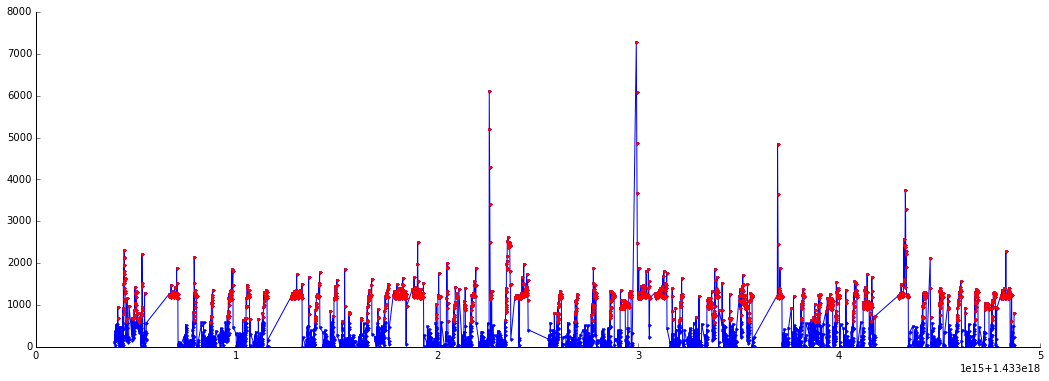

In [491]:
plt.figure(figsize=(18, 6))
plt.plot(delays.date_time, delays.delay, '-b.')
plt.plot(delays[delays['delay']>600].date_time, delays[delays['delay']>600].delay, 'r.')
remove_border()
plt.show()

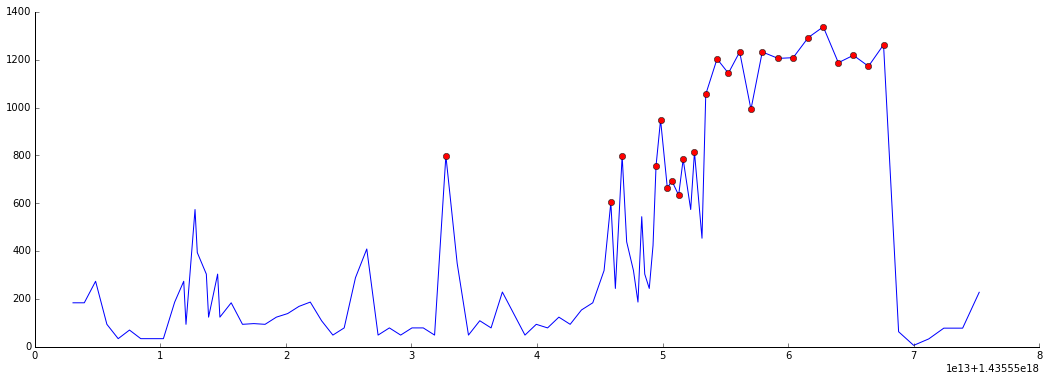

In [515]:
d = '2015-06-29'
plt.figure(figsize=(18, 6))
plt.plot(delays[(delays['train_date']==d)].date_time, \
         delays[(delays['train_date']==d)].delay)
plt.plot(delays[(delays['delay']>600)&(delays['train_date']==d)].date_time, \
         delays[(delays['delay']>600)&(delays['train_date']==d)].delay, 'ro')
remove_border()
plt.show()

one thing to note: with the schedules, for example for route 2, even though they all start milbrae and end at pittsburgh, the trains dont actually travel the whole route or stop at every station. if we look at sched_routesched there are stations where origtime is missing. this is mostly the case where the train doesnt start at the very beginning or end at the very end. there are also cases where it skips stations. this is all too coordinated in my opinion for bart to "throttle" as suggested above, but we will continue to investigate.

#weather

##current

In [564]:
exec_pd('describe weather_current;')

,0,1,2,3,4,5
0,uid,bigint(20),NO,PRI,None,auto_increment
1,reception_time,varchar(19),YES,,None,
2,location,varchar(21),YES,,None,
3,clouds,smallint(6),YES,,None,
4,detailed_status,varchar(30),YES,,None,
5,dewpoint,varchar(5),YES,,None,
6,heat_index,varchar(4),YES,,None,
7,humidex,varchar(4),YES,,None,
8,humidity,smallint(6),YES,,None,
9,pressure_pres,float,YES,,None,


In [572]:
exec_pd("select location, count(*) from weather_current where location in ('Emeryville', 'Piedmont', 'Berkeley') group by location")

,0,1
0,Berkeley,81059
1,Emeryville,117161
2,Piedmont,117248


dewpoint, heatindex, and humidex are always null. snow is 0 for when we have data. we will not pull these values.

In [586]:
columns = ['reception_time', 'location', 'clouds', 'humidity', 'pressure_pres', 'rain', \
           'status', 'temperature_temp', 'visibility_dist', 'wind_deg', 'wind_speed']
weather_current = exec_pd("select reception_time, location, clouds, humidity, pressure_pres, rain, status, temperature_temp, visibility_dist, wind_deg, wind_speed from weather_current where location = Piedmont'")
weather_current.columns = columns
weather_current.head()

,reception_time,location,clouds,humidity,pressure_pres,rain,status,temperature_temp,visibility_dist,wind_deg,wind_speed
0,2015-07-14 07:00:52,Berkeley,1,78,1011,0,rain,289.21,0,240,2.1
1,2015-07-14 07:01:28,Berkeley,90,87,1013,0,rain,288.53,0,260,5.1
2,2015-07-14 07:02:04,Berkeley,1,78,1011,0,rain,289.21,0,240,2.1
3,2015-07-14 07:02:41,Berkeley,1,78,1011,0,rain,289.21,0,240,2.1
4,2015-07-14 07:03:17,Berkeley,90,87,1013,0,rain,288.53,0,260,5.1


In [585]:
weather_current.describe()

,clouds,humidity,pressure_pres,rain,temperature_temp,visibility_dist,wind_deg,wind_speed
count,315468.000000,315468.000000,315468.000000,315468.000000,315468.000000,315468.000000,315468.000000,315468.000000
mean,41.182361,75.255512,1014.448889,0.000616,293.024607,2304.954426,229.214811,3.658361
std,36.375204,14.217394,4.003465,0.009364,5.023954,5374.567326,89.462942,1.874995
min,0.000000,14.000000,1002.000000,0.000000,283.068000,0.000000,0.000000,0.310000
25%,1.000000,68.000000,1012.000000,0.000000,289.410000,0.000000,210.507000,2.100000
50%,40.000000,77.000000,1015.000000,0.000000,291.710000,0.000000,248.507000,3.160000
75%,75.000000,83.000000,1017.000000,0.000000,296.740000,0.000000,280.000000,4.600000
max,90.000000,100.000000,1023.330000,0.155000,308.140000,16093.000000,361.000000,15.400000


##forecast

In [589]:
exec_pd('describe weather_forecast;')

,0,1,2,3,4,5
0,uid,bigint(20),NO,PRI,None,auto_increment
1,reception_time,varchar(19),YES,,None,
2,location,varchar(21),YES,,None,
3,clouds_3,smallint(6),YES,,None,
4,detailed_status_3,varchar(30),YES,,None,
5,dewpoint_3,varchar(5),YES,,None,
6,heat_index_3,varchar(4),YES,,None,
7,humidex_3,varchar(4),YES,,None,
8,humidity_3,smallint(6),YES,,None,
9,pressure_pres_3,float,YES,,None,


In [599]:
columns = ['reception_time', 'location', 'clouds_9', 'humidity_9', 'pressure_pres_9', 'rain_9', \
           'status_9', 'temperature_temp_9', 'visibility_dist_9', 'wind_deg_9', 'wind_speed_9', \
           'clouds_12', 'humidity_12', 'pressure_pres_12', 'rain_12', 'status_12', 'temperature_temp_12', \
           'visibility_dist_12', 'wind_deg_12', 'wind_speed_12']
weather_forecast = exec_pd("select reception_time, location, clouds_9, humidity_9, pressure_pres_9, rain_9, status_9, temperature_temp_9, visibility_dist_9, wind_deg_9, wind_speed_9, clouds_12, humidity_12, pressure_pres_12, rain_12, status_12, temperature_temp_12, visibility_dist_12, wind_deg_12, wind_speed_12 from weather_forecast where location = 'Piedmont'")
weather_forecast.columns = columns
weather_forecast.head()

,reception_time,location,clouds_9,humidity_9,pressure_pres_9,rain_9,status_9,temperature_temp_9,visibility_dist_9,wind_deg_9,wind_speed_9,clouds_12,humidity_12,pressure_pres_12,rain_12,status_12,temperature_temp_12,visibility_dist_12,wind_deg_12,wind_speed_12
0,2015-06-26 01:27:32,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66
1,2015-06-26 01:28:07,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66
2,2015-06-26 01:28:46,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66
3,2015-06-26 01:29:22,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66
4,2015-06-26 01:29:58,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66


In [598]:
weather_forecast.shape

(349624, 20)